# Part 1: NLP

In [41]:
# Imports

import pandas as pd
import spacy
import matplotlib.pyplot as plt
import nltk

import tensorflow as tf
import numpy as np
import seaborn as sns

## Import Modeling Package
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, Pipeline
from tensorflow.keras.models import Sequential



from sklearn.naive_bayes import MultinomialNB
# Set Random Seeds
tf.keras.utils.set_random_seed(42)
tf.random.set_seed(42)
np.random.seed(42)

In [42]:
# Increase column width
pd.set_option('display.max_colwidth', 250)

## Preprocessing

### Load functions

In [43]:
%load_ext autoreload
%autoreload 2

import exam_functions as fn

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Load in the text classification dataframe from the provided file (part1-aml-belt-exam.csv)

In [44]:
df = pd.read_csv('Data/part1-aml-belt-exam.csv')
df.head()

,source,paragraph
0,Christie,"thought to be an Englishman, but they never got any clue as to his"
1,Christie,“Who?” The word came faintly between her parted lips.
2,Christie,"“Doesn’t sound likely to me,” said the inspector. “But—well, can"
3,Christie,The coincidence was rather startling. Could it be possible that
4,Christie,"The thing seemed simple enough, but Pagett is a person who loves"


### Load the en_core_web_sm version of the spacy pipeline with the parser and ner disabled.

In [45]:
nlp_lite = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
nlp_lite

### Preprocess with spacy

#### Create a column with Tokenized text (no stopwords)

In [46]:
%%time

df['tokens']= fn.batch_preprocess_texts(df['paragraph'],nlp=nlp_lite, remove_stopwords = True, remove_punct =True, use_lemmas = False,)
                                        
   

27573it [00:33, 824.41it/s] 


CPU times: user 9.1 s, sys: 384 ms, total: 9.49 s
Wall time: 33.5 s


#### Create a column with Lemmatized text (no stopwords)

In [47]:
%%time
df['lemmas']= fn.batch_preprocess_texts(df['paragraph'],nlp=nlp_lite, remove_stopwords = True, remove_punct =True, use_lemmas = True,)
                                        
   

27573it [00:30, 896.86it/s] 

CPU times: user 8.93 s, sys: 347 ms, total: 9.28 s
Wall time: 30.8 s


In [48]:
df.head()

,source,paragraph,tokens,lemmas
0,Christie,"thought to be an Englishman, but they never got any clue as to his","[thought, englishman, got, clue]","[think, englishman, get, clue]"
1,Christie,“Who?” The word came faintly between her parted lips.,"[word, came, faintly, parted, lips]","[word, come, faintly, part, lip]"
2,Christie,"“Doesn’t sound likely to me,” said the inspector. “But—well, can","[sound, likely, said, inspector]","[sound, likely, say, inspector]"
3,Christie,The coincidence was rather startling. Could it be possible that,"[coincidence, startling, possible]","[coincidence, startling, possible]"
4,Christie,"The thing seemed simple enough, but Pagett is a person who loves","[thing, simple, pagett, person, loves]","[thing, simple, pagett, person, love]"


#### Create a column with the tokens for each text joined together as a single string.

In [49]:
df['joined_tokens'] = df['tokens'].map(lambda x: " ".join(x))

In [50]:
df['joined_tokens']

0                               thought englishman got clue
1                             word came faintly parted lips
2                               sound likely said inspector
3                            coincidence startling possible
4                          thing simple pagett person loves
                                ...                        
27568                      accentuated permission ask favor
27569                                   face unduly flushed
27570                              pulling impatiently bell
27571    yes answered laughing singular document philosophy
27572     mentioned earlier narrative like broad red church
Name: joined_tokens, Length: 27573, dtype: object

#### Create a column with the lemmas for each text joined together as a single string.

In [51]:
df['joined_lemmas'] = df['lemmas'].map(lambda x: " ".join(x))

In [52]:
df['joined_lemmas']

0                            think englishman get clue
1                           word come faintly part lip
2                           sound likely say inspector
3                       coincidence startling possible
4                      thing simple pagett person love
                             ...                      
27568                  accentuate permission ask favor
27569                              face unduly flushed
27570                            pull impatiently bell
27571    yes answer laugh singular document philosophy
27572    mention early narrative like broad red church
Name: joined_lemmas, Length: 27573, dtype: object

## Perform group comparison EDA:

### Define/separate two groups based on the source of the text (Conan Doyle or Christie)

In [53]:
df['source'].value_counts()

Conan Doyle    15016
Christie       12557
Name: source, dtype: int64

In [54]:
grp_ConanDoyle = df.loc[df['source'] == 'Conan Doyle']

In [55]:
grp_ConanDoyle

,source,paragraph,tokens,lemmas,joined_tokens,joined_lemmas
7,Conan Doyle,"block of a house, whitewashed, but all stained and streaked with damp","[block, house, whitewashed, stained, streaked, damp]","[block, house, whitewash, stain, streak, damp]",block house whitewashed stained streaked damp,block house whitewash stain streak damp
8,Conan Doyle,"glance showed me the unconscious Summerlee, most futile of sentinels,","[glance, showed, unconscious, summerlee, futile, sentinels]","[glance, show, unconscious, summerlee, futile, sentinel]",glance showed unconscious summerlee futile sentinels,glance show unconscious summerlee futile sentinel
12,Conan Doyle,me again with the same questioning and thoughtful look.,"[questioning, thoughtful, look]","[questioning, thoughtful, look]",questioning thoughtful look,questioning thoughtful look
13,Conan Doyle,Immediately beneath the cliff there grew a considerable patch of high,"[immediately, beneath, cliff, grew, considerable, patch, high]","[immediately, beneath, cliff, grow, considerable, patch, high]",immediately beneath cliff grew considerable patch high,immediately beneath cliff grow considerable patch high
15,Conan Doyle,"throwing-stick, or his arrow avail him against such forces as have been","[throwing, stick, arrow, avail, forces]","[throwing, stick, arrow, avail, force]",throwing stick arrow avail forces,throwing stick arrow avail force
...,...,...,...,...,...,...
27563,Conan Doyle,He picked it up and gazed at it in the peculiar introspective fashion,"[picked, gazed, peculiar, introspective, fashion]","[pick, gaze, peculiar, introspective, fashion]",picked gazed peculiar introspective fashion,pick gaze peculiar introspective fashion
27565,Conan Doyle,them to act as guides. After many adventures which I need not,"[act, guides, adventures, need]","[act, guide, adventure, need]",act guides adventures need,act guide adventure need
27568,Conan Doyle,"over-accentuated? With your permission, I would ask the favor of an","[accentuated, permission, ask, favor]","[accentuate, permission, ask, favor]",accentuated permission ask favor,accentuate permission ask favor
27571,Conan Doyle,"“Yes,” I answered, laughing. “It was a singular document. Philosophy,","[yes, answered, laughing, singular, document, philosophy]","[yes, answer, laugh, singular, document, philosophy]",yes answered laughing singular document philosophy,yes answer laugh singular document philosophy


In [56]:
grp_Christie = df.loc[df['source'] == 'Christie']

### Create word clouds for each group using raw text.

In [57]:
# get the text for group CananDoyle and display

grp_ConanDoyle_text = " ".join(grp_ConanDoyle['paragraph'])
print(grp_ConanDoyle_text[:500],"\n")

block of a house, whitewashed, but all stained and streaked with damp glance showed me the unconscious Summerlee, most futile of sentinels, me again with the same questioning and thoughtful look. Immediately beneath the cliff there grew a considerable patch of high throwing-stick, or his arrow avail him against such forces as have been every Saturday for the London Irish.  I'm not the man----" did to that of your friend. As to reward, my profession is its own thinking that Blundell got him at th 



In [58]:
# get the text for group Christie and display

grp_Christie_text = " ".join(grp_Christie['paragraph'])
print(grp_Christie_text[:500],"\n")

thought to be an Englishman, but they never got any clue as to his “Who?” The word came faintly between her parted lips. “Doesn’t sound likely to me,” said the inspector. “But—well, can The coincidence was rather startling. Could it be possible that The thing seemed simple enough, but Pagett is a person who loves We thanked our informant, and drove on, leaving the town behind. A fork Lord Nasby stretched out a careless hand. “What was he like?” Then I started to jump to conclusions. Not knowing  



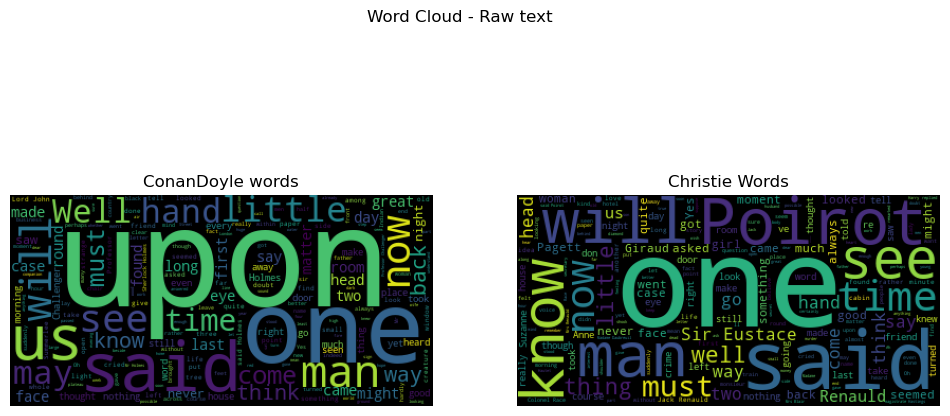

In [59]:
# Create a word clouds of above texts

from wordcloud import WordCloud, STOPWORDS
ConanDoyle_cloud = WordCloud(min_word_length=2).generate(grp_ConanDoyle_text)
Christie_cloud = WordCloud(min_word_length=2).generate(grp_Christie_text)

## Plot the Images

fig, axes = plt.subplots(ncols=2, figsize=(12, 6))
axes[0].imshow(ConanDoyle_cloud)
axes[0].set_title('ConanDoyle words')
axes[0].axis('off')

axes[1].imshow(Christie_cloud)
axes[1].set_title('Christie Words')
axes[1].axis('off');
fig.suptitle('Word Cloud - Raw text');

### Create word clouds for each group using lemmatized text.

In [60]:
# get the text for group CananDoyle and display

grp_ConanDoyle_text = " ".join(grp_ConanDoyle['joined_lemmas'])
print(grp_ConanDoyle_text[:500],"\n")

# get the text for group Christie and display

grp_Christie_text = " ".join(grp_Christie['joined_lemmas'])
print(grp_Christie_text[:500],"\n")

block house whitewash stain streak damp glance show unconscious summerlee futile sentinel questioning thoughtful look immediately beneath cliff grow considerable patch high throwing stick arrow avail force saturday london irish man---- friend reward profession think blundell get wrong moment maybe time go door knock instantly far river good day miss hunter strike gong table attempt establish practice london take live slop shop gin shop approach steep flight abroad fail health time business water 

think englishman get clue word come faintly part lip sound likely say inspector coincidence startling possible thing simple pagett person love thank informant drive leave town fork lord nasby stretch careless hand like start jump conclusion know sir eustace enter give nod dismissal go leave huddle garment step cool night know nearly o’clock hate uncomfortable address take time irregular secret passage room find find possible witness think know right know world obvious m. renauld write letter 

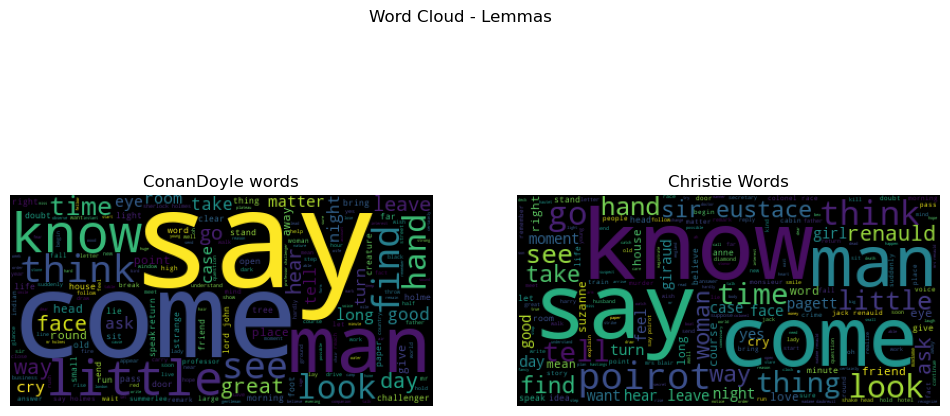

In [61]:
# Create a word clouds of above texts

from wordcloud import WordCloud, STOPWORDS
ConanDoyle_cloud = WordCloud(min_word_length=2).generate(grp_ConanDoyle_text)
Christie_cloud = WordCloud(min_word_length=2).generate(grp_Christie_text)

## Plot the Images

fig, axes = plt.subplots(ncols=2, figsize=(12, 6))
axes[0].imshow(ConanDoyle_cloud)
axes[0].set_title('ConanDoyle words')
axes[0].axis('off')

axes[1].imshow(Christie_cloud)
axes[1].set_title('Christie Words')
axes[1].axis('off')
fig.suptitle('Word Cloud - Lemmas');

### Display the top 20 most frequent bigrams for both groups in a single dataframe
- Tip/Note: When making the exploded list of tokens, you must include .astype(str) to ensure all tokens are strings. If you do not, you will get an error message! You can chain the methods together as follows:  .explode().astype(str).to_list()

In [62]:
grp_ConanDoyle_tokens = grp_ConanDoyle['tokens'].explode().astype(str).to_list()

In [63]:
grp_Christie_tokens = grp_Christie['tokens'].explode().astype(str).to_list()

In [64]:
grp_ConanDoyle_tokens

['block',
 'house',
 'whitewashed',
 'stained',
 'streaked',
 'damp',
 'glance',
 'showed',
 'unconscious',
 'summerlee',
 'futile',
 'sentinels',
 'questioning',
 'thoughtful',
 'look',
 'immediately',
 'beneath',
 'cliff',
 'grew',
 'considerable',
 'patch',
 'high',
 'throwing',
 'stick',
 'arrow',
 'avail',
 'forces',
 'saturday',
 'london',
 'irish',
 'man----',
 'friend',
 'reward',
 'profession',
 'thinking',
 'blundell',
 'got',
 'wrong',
 'moment',
 'maybe',
 'times',
 'went',
 'door',
 'knocked',
 'instantly',
 'far',
 'river',
 'good',
 'day',
 'miss',
 'hunter',
 'struck',
 'gong',
 'table',
 'attempts',
 'establish',
 'practice',
 'london',
 'took',
 'live',
 'slop',
 'shop',
 'gin',
 'shop',
 'approached',
 'steep',
 'flight',
 'abroad',
 'failing',
 'health',
 'time',
 'business',
 'water',
 'carafe',
 'table',
 'humorous',
 'twinkling',
 'aside',
 'let',
 'wailed',
 'answered',
 'utmost',
 'coolness',
 'fancy',
 'hinted',
 'trouble',
 'professor',
 'baggage',
 'gave',
 

In [65]:
grp_Christie_tokens

['thought',
 'englishman',
 'got',
 'clue',
 'word',
 'came',
 'faintly',
 'parted',
 'lips',
 'sound',
 'likely',
 'said',
 'inspector',
 'coincidence',
 'startling',
 'possible',
 'thing',
 'simple',
 'pagett',
 'person',
 'loves',
 'thanked',
 'informant',
 'drove',
 'leaving',
 'town',
 'fork',
 'lord',
 'nasby',
 'stretched',
 'careless',
 'hand',
 'like',
 'started',
 'jump',
 'conclusions',
 'knowing',
 'sir',
 'eustace',
 'entered',
 'gave',
 'nod',
 'dismissal',
 'went',
 'leaving',
 'huddled',
 'garments',
 'stepped',
 'cool',
 'night',
 'know',
 'nearly',
 'o’clock',
 'hates',
 'uncomfortable',
 'address',
 'taken',
 'time',
 'irregular',
 'secret',
 'passage',
 'room',
 'found',
 'find',
 'possible',
 'witness',
 'think',
 'know',
 'right',
 'know',
 'world',
 'obvious',
 'm.',
 'renauld',
 'wrote',
 'letter',
 'blotting',
 'reread',
 'chapter',
 'viii',
 'gives',
 'write',
 'enormous',
 'pleasure',
 'know',
 'monsieur',
 'wish',
 'occasion',
 'distress',
 'supporting',
 'a

In [66]:
# using custom function get_ngram_measures_finder to get the bigrams

bigram_grp_ConanDoyle = fn.get_ngram_measures_finder(grp_ConanDoyle_tokens,top_n=20)

bigram_grp_Christie = fn.get_ngram_measures_finder(grp_Christie_tokens,top_n=20)

In [67]:
bigram_grp_ConanDoyle,bigram_grp_Christie

(                      Words  Raw Freq
 0              (lord, john)  0.001841
 1            (said, holmes)  0.001525
 2        (sherlock, holmes)  0.001280
 3             (mr., holmes)  0.000978
 4   (professor, challenger)  0.000920
 5                (said, i.)  0.000547
 6                (ape, men)  0.000532
 7              (st., simon)  0.000503
 8    (professor, summerlee)  0.000431
 9              (said, lord)  0.000417
 10              (lord, st.)  0.000403
 11           (john, roxton)  0.000374
 12          (baker, street)  0.000360
 13             (st., clair)  0.000345
 14           (maple, white)  0.000331
 15          (young, fellah)  0.000331
 16            (red, headed)  0.000316
 17       (said, challenger)  0.000316
 18            (young, lady)  0.000302
 19             (young, man)  0.000288,
                       Words  Raw Freq
 0            (sir, eustace)  0.003736
 1             (m., renauld)  0.001923
 2           (jack, renauld)  0.001777
 3           (colonel, r

## Text Classification - Machine Learning


### Build, fit, and evaluate a binary MultinomialNB classifier to predict the author (source) from the original raw paragraphs text. 
- Do not remove stopwords
- No need to  balance the dataset
- Use a pipeline to include the count vectorizer and classification model
- You do not need to tune the model
- Save your model pipeline to a Models folder in your repo as a joblib file.

In [68]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27573 entries, 0 to 27572
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   source         27573 non-null  object
 1   paragraph      27573 non-null  object
 2   tokens         27573 non-null  object
 3   lemmas         27573 non-null  object
 4   joined_tokens  27573 non-null  object
 5   joined_lemmas  27573 non-null  object
dtypes: object(6)
memory usage: 1.3+ MB


**#define X and y**

In [69]:
# define X and y

X = df['paragraph']
y = df['source']


In [70]:
# No need to balance the dataset though lets check the balance for information

y.value_counts()

Conan Doyle    15016
Christie       12557
Name: source, dtype: int64

**# Train Test Split**

In [71]:
# Train Test Split

X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=42)


**# Modeling using MultinomialNB classifier**

In [72]:
# Modeling

# using raw text (paragraph) , creating pipeline with count vectorizer and classification model

## Create a model pipeline for inference.
nb_clf = MultinomialNB()

nb_pipe = Pipeline([('countvectorizer', CountVectorizer()), 
                       ('nb_classifier', nb_clf)])

#nb_pipe.fit(X_train, y_train)

In [74]:
nb_pipe.fit(X_train, y_train)

Pipeline(steps=[('countvectorizer', CountVectorizer()),
                ('nb_classifier', MultinomialNB())])

In [79]:
# # Fit and transform on the training data
# X_train_transformed = nb_pipe.named_steps['countvectorizer'].fit_transform(X_train)

# # Transform the testing data
# X_test_transformed = nb_pipe.named_steps['countvectorizer'].transform(X_test)

# # Now you can use X_train_transformed and X_test_transformed in your machine learning model


----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

    Christie       0.87      0.87      0.87      9380
 Conan Doyle       0.89      0.90      0.89     11299

    accuracy                           0.88     20679
   macro avg       0.88      0.88      0.88     20679
weighted avg       0.88      0.88      0.88     20679



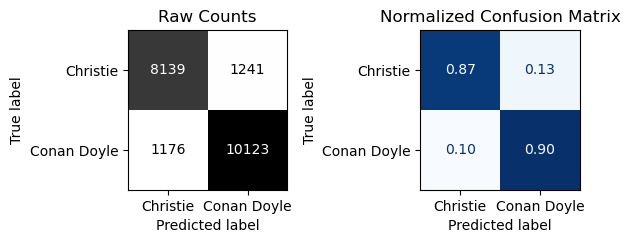


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

    Christie       0.81      0.77      0.79      3177
 Conan Doyle       0.81      0.85      0.83      3717

    accuracy                           0.81      6894
   macro avg       0.81      0.81      0.81      6894
weighted avg       0.81      0.81      0.81      6894



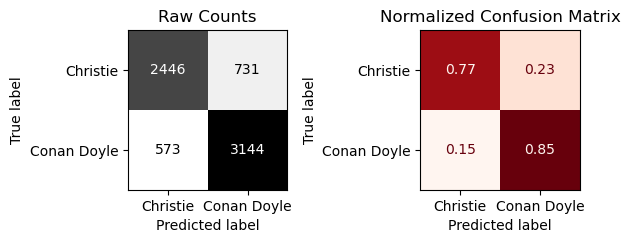

In [33]:
# using custom classification evaluation function to evaluate

fn.evaluate_classification(nb_pipe, X_train, y_train, X_test, y_test)

**# Save your model pipeline to a Models folder in your repo as a joblib file.**

In [34]:
import os

os.makedirs('Models/' ,exist_ok =True)

In [35]:
import joblib
fpath_model = "Models/nb_classifierexam.joblib"
joblib.dump(nb_pipe, fpath_model)

['Models/nb_classifierexam.joblib']

## Text Classification - Deep NLP

### Prepare tensorflow datasets for a train/val/test split
- No need to balance classes
- Note: Make sure your target is encoded numerically (integers).
- Use a batch size of 32.
- Select a sequence length appropriate for the dataset's text.
    - Add a column to the dataframe that has the length of each paragraph
    - Use the maximum length as the sequence length
        - Note: if your computer is having memory/PC issues when fitting the model, reduce the sequence length and add a comment listing the maximum length and why you had to reduce it)


In [36]:
# Make sure your target is encoded numerically (integers)
# Use labelencoder to encode the target 

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_encoded = le.fit_transform(y)
y_encoded

array([0, 0, 0, ..., 0, 1, 1])

In [37]:
# Use a batch size of 32
BATCH_SIZE =32

In [38]:
df['paragraph']

0           thought to be an Englishman, but they never got any clue as to his
1                        “Who?” The word came faintly between her parted lips.
2             “Doesn’t sound likely to me,” said the inspector. “But—well, can
3              The coincidence was rather startling. Could it be possible that
4             The thing seemed simple enough, but Pagett is a person who loves
                                         ...                                  
27568     over-accentuated?  With your permission, I would ask the favor of an
27569                         side to side, and his face still unduly flushed.
27570                                         pulling impatiently at the bell.
27571    “Yes,” I answered, laughing. “It was a singular document. Philosophy,
27572      mentioned earlier in this narrative.  It is like a broad red church
Name: paragraph, Length: 27573, dtype: object

In [39]:
# Add a column to the dataframe that has the length of each paragraph

# Let's take a look at the length of the each text
# We will split on each space, and then get the length
df['sequence_length'] =df['paragraph'].map( lambda x: len(x.split(" ")))
df.head()

,source,paragraph,tokens,lemmas,joined_tokens,joined_lemmas,sequence_length
0,Christie,"thought to be an Englishman, but they never got any clue as to his","[thought, englishman, got, clue]","[think, englishman, get, clue]",thought englishman got clue,think englishman get clue,14
1,Christie,“Who?” The word came faintly between her parted lips.,"[word, came, faintly, parted, lips]","[word, come, faintly, part, lip]",word came faintly parted lips,word come faintly part lip,9
2,Christie,"“Doesn’t sound likely to me,” said the inspector. “But—well, can","[sound, likely, said, inspector]","[sound, likely, say, inspector]",sound likely said inspector,sound likely say inspector,10
3,Christie,The coincidence was rather startling. Could it be possible that,"[coincidence, startling, possible]","[coincidence, startling, possible]",coincidence startling possible,coincidence startling possible,10
4,Christie,"The thing seemed simple enough, but Pagett is a person who loves","[thing, simple, pagett, person, loves]","[thing, simple, pagett, person, love]",thing simple pagett person loves,thing simple pagett person love,12


In [40]:
df['sequence_length'].describe()

count    27573.000000
mean        11.625648
std          2.986672
min          4.000000
25%         10.000000
50%         12.000000
75%         14.000000
max         33.000000
Name: sequence_length, dtype: float64

**The range of sequence length is from 4 to 33**

**Lets take maximum sequence length as 40**

In [41]:
SEQUENCE_LENGTH = 40

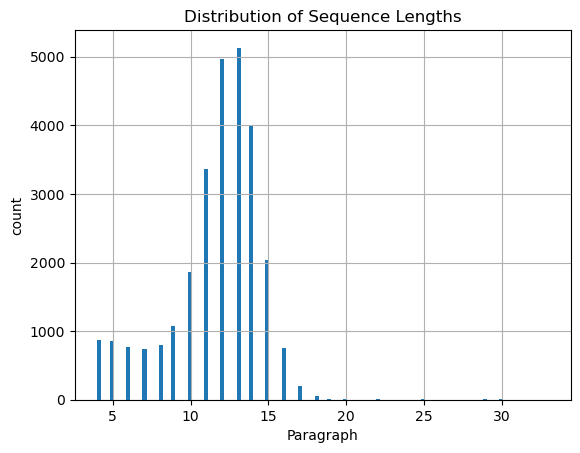

In [42]:
# Make histogram of sequence lengths
ax = df['sequence_length'].hist(bins = 'auto')
ax.set_xlabel('Paragraph')
ax.set_ylabel('count')
ax.set_title('Distribution of Sequence Lengths');

In [43]:
# prepare the dataset for modeling

print(X)

0           thought to be an Englishman, but they never got any clue as to his
1                        “Who?” The word came faintly between her parted lips.
2             “Doesn’t sound likely to me,” said the inspector. “But—well, can
3              The coincidence was rather startling. Could it be possible that
4             The thing seemed simple enough, but Pagett is a person who loves
                                         ...                                  
27568     over-accentuated?  With your permission, I would ask the favor of an
27569                         side to side, and his face still unduly flushed.
27570                                         pulling impatiently at the bell.
27571    “Yes,” I answered, laughing. “It was a singular document. Philosophy,
27572      mentioned earlier in this narrative.  It is like a broad red church
Name: paragraph, Length: 27573, dtype: object


In [44]:
print(y_encoded)

[0 0 0 ... 0 1 1]


In [45]:
classes = np.unique(y_encoded)
classes

array([0, 1])

#### Convert to a dataset object using Dataset.from_tensor_slices()

In [46]:
# Convert to a dataset object using Dataset.from_tensor_slices()

ds = tf.data.Dataset.from_tensor_slices((X, y_encoded))

# Shuffle dataset
ds = ds.shuffle(buffer_size=len(ds),reshuffle_each_iteration=False) 

Metal device set to: Apple M1 Pro


#### Train, test, split with a .7, .2, .1 ratio using the take, skip, approach

In [47]:
# Train, test, split with a .7, .2, .1 ratio using the take, skip, approach

# Set the ratio of the train, validation, test split
split_train = .7
split_val =  .2
split_test =  1 -( split_train + split_val )

# Calculate the number of samples for training and validation data 
n_train_samples =  int(len(ds) * split_train)
n_val_samples = int(len(ds) * split_val)
n_test_samples = len(ds) -(n_train_samples + n_val_samples)

import math
# math.ceil will round up
# How many batches? 
n_train_batches = math.ceil(n_train_samples/BATCH_SIZE)
n_val_batches = math.ceil(n_val_samples/BATCH_SIZE)
n_test_batches = math.ceil(n_test_samples/BATCH_SIZE)

print(f"    - train:\t{n_train_samples} samples \t({n_train_batches} batches)")
print(f"    - val:  \t{n_val_samples} samples \t({n_val_batches} batches)")
print(f"    - test: \t{n_test_samples} samples \t({n_test_batches} batches)")


    - train:	19301 samples 	(604 batches)
    - val:  	5514 samples 	(173 batches)
    - test: 	2758 samples 	(87 batches)


In [48]:
# Use take and skip to define each set
train_ds = ds.take(n_train_samples).batch(batch_size=BATCH_SIZE)

# Skip over the training batches and take the validation batches
val_ds = ds.skip(n_train_samples).take(n_val_samples).batch(batch_size=BATCH_SIZE)

# Skipver the train and validation batches, the remaining are the test batches
test_ds = ds.skip(n_train_samples + n_val_samples).batch(batch_size=BATCH_SIZE)

In [49]:
# Confirm the number of batches in each
print (f' There are {len(train_ds)} training batches.')
print (f' There are {len(val_ds)} validation batches.')
print (f' There are {len(test_ds)} testing batches.')

 There are 604 training batches.
 There are 173 validation batches.
 There are 87 testing batches.


### Build, fit, and evaluate a binary classification sequence model

- Include a Keras TextVectorization as a layer in your model.
- Use 100 as the embedding dimension/size
- Use a bidirectional GRU

#### Keras TextVectorization as a layer in your model.

In [50]:
SEQUENCE_LENGTH = 40
# Create text Vectorization layer
text_vectorizer = tf.keras.layers.TextVectorization(
    standardize="lower_and_strip_punctuation",
    output_mode="int",
    output_sequence_length=SEQUENCE_LENGTH
)

In [51]:
# Get just the text from ds_train
ds_texts = train_ds.map(lambda x, y_encoded: x)

# Preview the text
ds_texts.take(1).get_single_element()

2024-01-18 10:58:29.967064: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


<tf.Tensor: shape=(32,), dtype=string, numpy=
array([b'It was indeed a gigantic one, and capable of exercising enormous',
       b'our protection.  With an expressive sweep of his hands one of them',
       b'to sign a paper, so that whether she married or not, he could use her',
       b'port-holes of a liner in the darkness.  For a moment I thought it was',
       b'He considered for a minute.',
       b'moonshine I saw what it was. It was a giant dog, as large as a calf,',
       b'boiling kettle or the bubbling of some great pot.  Soon I came upon the',
       b'us--but beyond these sounds there were no signs of life.',
       b'ask for assistance. I saw no one near my father when I returned, and I',
       b'message, threw it across to me.',
       b'noted them.  If my expedition had no other results it would still have',
       b'\xe2\x80\x9cLord Robert St. Simon,\xe2\x80\x9d announced our page-boy, throwing open the',
       b'"Challenger was the man who came with some cock-and-

In [52]:
# Train (adapt on training text data))
text_vectorizer.adapt(ds_texts)
text_vectorizer.vocabulary_size()

16932

In [53]:
# Programmatically define size of vocab from vectorization layer
VOCAB_SIZE = text_vectorizer.vocabulary_size()
VOCAB_SIZE

16932

#### Use 100 as the embedding dimension/size

In [54]:
EMBED_DIM = 100

In [55]:
print(f'VOCAB_SIZE is {VOCAB_SIZE}')
print(f'SEQUENCE_LENGTH is {SEQUENCE_LENGTH}')
print(f'EMBED_DIM is {EMBED_DIM}')

VOCAB_SIZE is 16932
SEQUENCE_LENGTH is 40
EMBED_DIM is 100


#### Use a bidirectional GRU

In [56]:
# using custom functions

from tensorflow.keras.models import Sequential
from tensorflow.keras import layers, optimizers, regularizers
def build_gru_model(text_vectorization_layer):
                
    gru_model = Sequential([
        text_vectorization_layer,
        tf.keras.layers.Embedding(input_dim=VOCAB_SIZE, 
                                  output_dim=EMBED_DIM, 
                                  input_length=SEQUENCE_LENGTH)])
    # Add GRU layer *new*
    gru_model.add(layers.GRU(128, return_sequences = True))   
    gru_model.add(layers.GlobalMaxPooling1D())
    # Output layer
    gru_model.add(layers.Dense(len(classes), 
                              activation='softmax'))
        
    optimizer = optimizers.legacy.Adam()
    gru_model.compile(optimizer=optimizer,  
                  loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    gru_model.summary()
    return gru_model


# Include callbacks
def get_callbacks(patience=3, monitor='val_accuracy'):
    early_stop = tf.keras.callbacks.EarlyStopping(patience=patience, monitor=monitor)
    return [early_stop]

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 40)               0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 40, 100)           1693200   
                                                                 
 gru (GRU)                   (None, 40, 128)           88320     
                                                                 
 global_max_pooling1d (Globa  (None, 128)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 2)                 258       
                                                                 
Total params: 1,781,778
Trainable params: 1,781,778
Non-

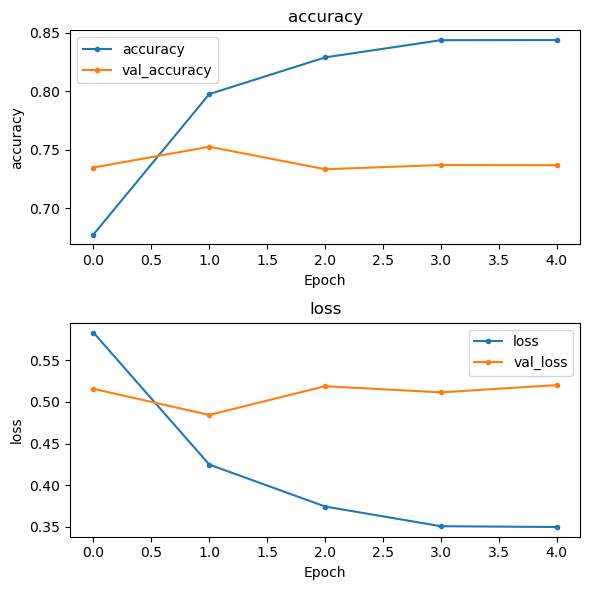


- Evaluating Network...
----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.78      0.86      0.82      8772
           1       0.88      0.80      0.84     10529

    accuracy                           0.83     19301
   macro avg       0.83      0.83      0.83     19301
weighted avg       0.83      0.83      0.83     19301



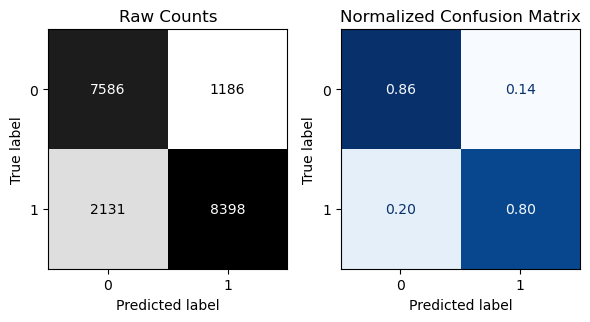


- Evaluating Training Data:
604/604 [==============================] - 5s 9ms/step - loss: 0.3744 - accuracy: 0.8281
{'loss': 0.3744329810142517, 'accuracy': 0.8281436562538147}
----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.70      0.77      0.73      1254
           1       0.79      0.72      0.75      1504

    accuracy                           0.74      2758
   macro avg       0.74      0.75      0.74      2758
weighted avg       0.75      0.74      0.74      2758



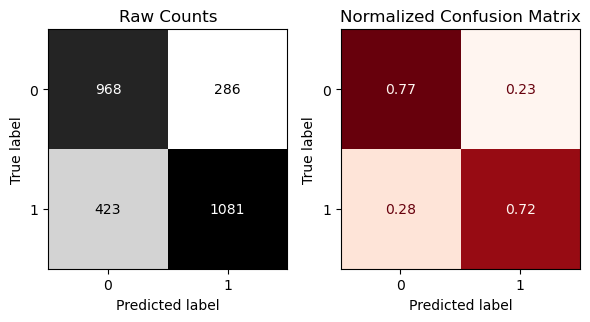


- Evaluating Test Data:
87/87 [==============================] - 1s 10ms/step - loss: 0.5097 - accuracy: 0.7429
{'loss': 0.5096977949142456, 'accuracy': 0.7429296374320984}


In [57]:
# Build the gru model and specify the vectorizer
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers, optimizers, regularizers

gru_model = build_gru_model(text_vectorizer)

# Defien number of epocs
EPOCHS = 30

# Fit the model
history = gru_model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
    callbacks=get_callbacks(),
)

# Obtain the results
results = fn.evaluate_classification_network(
    gru_model, X_train=train_ds, 
    X_test=test_ds, history=history
);

#### Save your model to a Models folder in your repo in the SavedModel format (save_format='tf').

In [62]:
fpath_model = "Models/gru"
#tf.keras.models.save_model(model, fpath_model)
gru_model.save(fpath_model, save_format='tf')


INFO:tensorflow:Assets written to: Models/gru/assets


INFO:tensorflow:Assets written to: Models/gru/assets


# Part 2: Model Deployment